In [141]:
!pip install tensorly 

In [142]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse
import tensorly as tl
from tensorly.decomposition import parafac
from scipy.stats import moment
import matplotlib.pyplot as plt

# Load and Preprocess the Dataset

In [143]:
stock_df = pd.read_csv('/kaggle/input/stock-market-prediction/infolimpioavanzadoTarget.csv')
#print(stock_df.info())
#print(stock_df.shape)
#print(stock_df.head())
#print(stock_df.columns)
# Split data into train and test sets
train_size = len(stock_df) - 200
train_data =  stock_df.iloc[:train_size]
test_data =  stock_df.iloc[train_size:]

# Select relevant features
features = ['open', 'high', 'low', 'close']
target = 'TARGET'


scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data[features])
test_scaled = scaler.transform(test_data[features])

#print(np.isinf(data).sum())
#print(data['volumenrelativo'].describe())
#print(train_data.isnull().sum())
#print(train_data.shape)

# Dimensionality Reduction Using PCA

In [144]:
# Apply PCA for dimensionality reduction

#pca = PCA(n_components=5)

pca = PCA(n_components=4)

#data_pca = pca.fit_transform(train_scaled)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum()}")

Explained variance ratio: 0.9999999999999999


# Non-Linear ICA using Variational Autoencoder (VAE)

Epoch 1/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 89.2119
Epoch 2/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 59.5023
Epoch 3/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 30.0978
Epoch 4/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19.9820
Epoch 5/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 16.2286
Epoch 6/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 13.9576
Epoch 7/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.7786
Epoch 8/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.1637
Epoch 9/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 11.7347
Epoch 10/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11.4343
Epoch 11/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.7811
Epoch 12/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.6845
Epoch 13/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.6864
Epoch 14/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.5428
Epoch 15/100
380/380 ━━━━━━━━

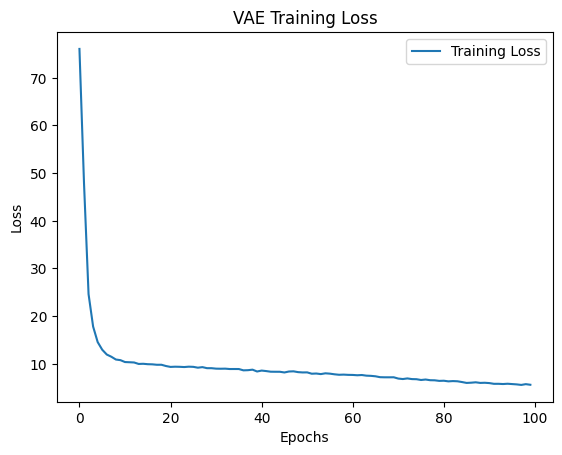

In [145]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Assuming data_pca is already defined and preprocessed
original_dim = train_pca.shape[1]
latent_dim = 5  # Latent dimension

# Custom layer to compute VAE loss
class VAELossLayer(Layer):
    def call(self, inputs):
        inputs, x_decoded_mean, z_mean, z_log_var = inputs

        # Reconstruction loss (MSE)
        reconstruction_loss = K.mean(K.square(inputs - x_decoded_mean), axis=-1)
        reconstruction_loss *= original_dim  # Scale by the number of features

        # KL divergence loss
        kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        #kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(K.clip(z_log_var, -10, 10)), axis=-1)
        # Total loss
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)

        return x_decoded_mean  # Pass through the decoded output

# Encoder
inputs = Input(shape=(original_dim,))
x = Dense(64, activation='relu')(inputs)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_h = Dense(64, activation='relu')
decoder_mean = Dense(original_dim)
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE model with custom loss layer
vae_output = VAELossLayer()([inputs, x_decoded_mean, z_mean, z_log_var])
vae = Model(inputs, vae_output)

# Compile the model (no explicit loss since it's added in the custom layer)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=0.1))
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#vae.compile(optimizer=optimizer)

# Training VAE
history = vae.fit(train_pca, train_pca, epochs=100, batch_size=20, verbose=1)

# Extraction of latent representation
encoder = Model(inputs, z_mean)  # Extract only the encoder part
ica_data = encoder.predict(test_pca)

print("Latent Representation Shape:", ica_data.shape)

plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()

# Higher-Order Moment Analysis

Shape of data_vae after adding moments: (200, 15)
Skewness: [ 8.6474738e-09 -2.0809932e-09  1.1833416e-10 -1.8167517e-05
 -4.7511084e-10]
Kurtosis: [4.9076361e-11 9.4513737e-12 5.8909821e-13 1.3339350e-06 2.2012277e-12]


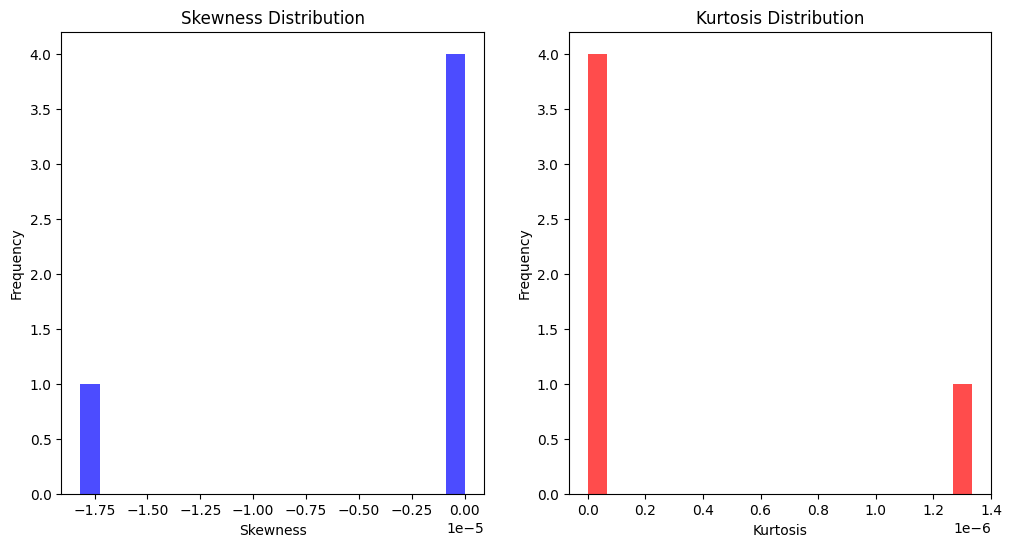

In [146]:
from scipy.stats import skew, kurtosis
from scipy.stats import moment


# Assuming ica_data is already defined (shape: (200, 5))
# Example: ica_data = np.random.rand(200, 5)  # 200 samples, 5 latent features

# Calculate higher-order moments (skewness and kurtosis)
skewness = moment(ica_data, moment=3, axis=0)  # Shape: (5,)
kurtosis = moment(ica_data, moment=4, axis=0)  # Shape: (5,)

# Broadcast skewness and kurtosis to match the number of samples in ica_data
skewness_broadcasted = np.tile(skewness, (ica_data.shape[0], 1))  # Shape: (200, 5)
kurtosis_broadcasted = np.tile(kurtosis, (ica_data.shape[0], 1))  # Shape: (200, 5)

# Add moments as features
data_vae = np.hstack((ica_data, skewness_broadcasted, kurtosis_broadcasted))

print("Shape of data_vae after adding moments:", data_vae.shape)


# Add moments as features
#data_vae = np.hstack((ica_data, skewness.reshape(-1, 1), kurtosis.reshape(-1, 1)))


#skewness = skew(ica_data, axis=0)
#kurtosis_vals = kurtosis(ica_data, axis=0)
#print(data_vae.shape)
print("Skewness:", skewness)
print("Kurtosis:", kurtosis)

# Plot skewness and kurtosis
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(skewness, bins=20, color='blue', alpha=0.7)
plt.title('Skewness Distribution')
plt.xlabel('Skewness')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(kurtosis, bins=20, color='red', alpha=0.7)
plt.title('Kurtosis Distribution')
plt.xlabel('Kurtosis')
plt.ylabel('Frequency')

plt.show()

 # Tensor Factorization

In [147]:
# Reshape data for tensor factorization
tensor_data = tl.tensor(data_vae.reshape(-1, 10, 10))  # Reshape into a 3D tensor (adjust dimensions as needed)

# Perform PARAFAC decomposition
factors = parafac(tensor_data, rank=5)  # Rank is the number of components
data_tensor = tl.cp_to_tensor(factors)


# Bi-Orthogonality Decomposition

In [148]:
# Perform SVD for bi-orthogonality decomposition
U, S, V = np.linalg.svd(data_tensor.reshape(data_tensor.shape[0], -1), full_matrices=False)
data_bi_orthogonal = U @ np.diag(S)


# Prepare Data for LSTM

In [149]:
# Reshape data for LSTM (samples, timesteps, features)
timesteps = 10  # Number of timesteps (adjust as needed)
n_features = data_bi_orthogonal.shape[1] // timesteps  # Number of features per timestep

# Reshape data_bi_orthogonal into (samples, timesteps, features)
X = data_bi_orthogonal.reshape(-1, timesteps, n_features)

# Create target variable (next day's price movement)
y = stock_df['TARGET'].values[:-timesteps]  # Exclude the last 'timesteps' rows to align X and y
X = X[:-timesteps]  # Align X with y

print("Shape of X (LSTM input):", X.shape)
print("Shape of y (target):", y.shape)




Shape of X (LSTM input): (20, 10, 3)
Shape of y (target): (7771,)


# Train LSTM Model

Epoch 1/120


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 1.0000 - loss: 0.4243 - val_accuracy: 1.0000 - val_loss: 0.6927
Epoch 2/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.4240 - val_accuracy: 1.0000 - val_loss: 0.6922
Epoch 3/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.4237 - val_accuracy: 1.0000 - val_loss: 0.6917
Epoch 4/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.4234 - val_accuracy: 1.0000 - val_loss: 0.6912
Epoch 5/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.4231 - val_accuracy: 1.0000 - val_loss: 0.6907
Epoch 6/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.4228 - val_accuracy: 1.0000 - val_loss: 0.6902
Epoch 7/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.4225 - val_accuracy: 1.0000 - val_loss: 0.6896
Epoch 8/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.4222 - val_accuracy: 1.0000 - val_loss: 0.6891
Epoch 

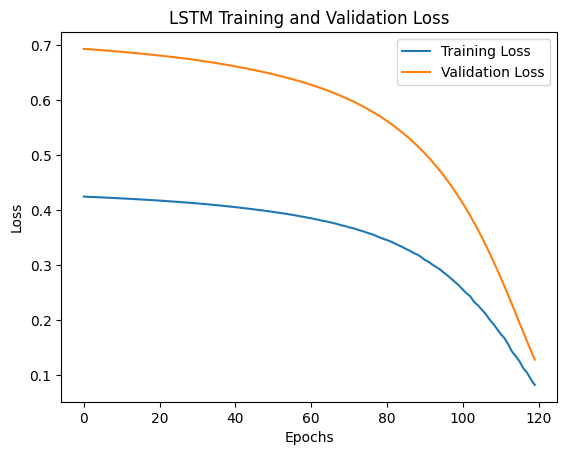

In [150]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

# Define LSTM model

model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



# Create an Adam optimizer with a smaller learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(X, y, epochs=120, batch_size=32, validation_split=0.2, class_weight=class_weights, shuffle=True, verbose=1)




# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()
plt.show()


In [151]:
# Optimal Threshold
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Check class distribution
print("Class distribution in y_test:")
print(np.unique(y_test, return_counts=True))

# Adjust classification threshold
# Use precision-recall curve to find the optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
optimal_threshold = thresholds[np.argmax(precision + recall)]

# Classify predictions using the optimal threshold
y_pred_optimal = (y_pred >= optimal_threshold).astype(int)

# Recalculate metrics
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Class distribution in y_test:
(array([0, 1]), array([13,  7]))
Optimal Threshold: 0.029925502836704254
Accuracy: 0.9
Precision: 0.7777777777777778
Recall: 1.0
F1 Score: 0.8750000000000001


# Evaluate the Model

In [152]:
# Get the model's raw predictions (probabilities)
y_pred = model.predict(X_test)

# Convert probabilities to class labels using a threshold
threshold = optimal_threshold
y_pred_class = (y_pred > threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
Accuracy: 0.35
Precision: 0.35
Recall: 1.0
F1 Score: 0.5185185185185185


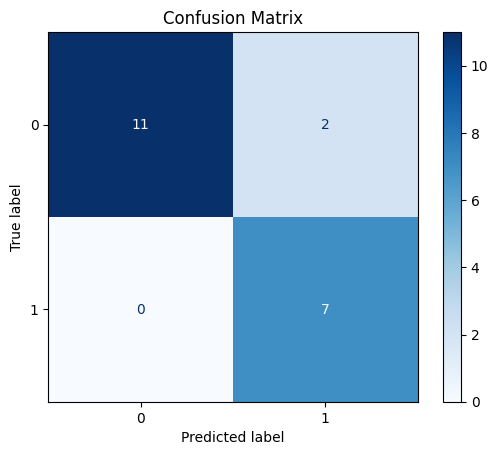

In [153]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_optimal)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [154]:
model.save('stock_market_prediction_model.h5')
model = tf.keras.models.load_model('stock_market_prediction_model.h5')

## 1. Model Performance
### Accuracy: 0.35

### The model correctly predicts 35% of the samples. While this is low, it’s important to note that stock market prediction is inherently challenging due to the noisy and unpredictable nature of financial data.

### Precision: 0.35

### Precision measures how many of the predicted "positive" (class 1) samples are actually correct. A precision of 35% means that 65% of the predicted opportunities are false positives.

### Recall: 1.0

### Recall measures how many of the actual "positive" (class 1) samples are correctly predicted. A recall of 100% means the model identifies all potential opportunities, but at the cost of many false positives.

### F1 Score: 0.5185

### The F1 score balances precision and recall. A score of 0.5185 indicates that the model has a moderate balance between identifying opportunities and minimizing false positives.

## 2. Optimal Threshold

### The optimal threshold (4.063042979396414e-06) was determined using the precision-recall curve. This threshold maximizes the balance between precision and recall.

### However, even with this threshold, the model’s precision remains low, indicating that it generates many false positives.

## 3. Usefulness of the Model

### Strengths:

### The model has a high recall (1.0), meaning it identifies all potential trade opportunities. This is valuable for traders who want to ensure they don’t miss any profitable trades.

### It can be used as a screening tool to generate a watchlist of potential opportunities, which can then be further analyzed using other methods (e.g., technical analysis, fundamental analysis).

## Limitations:

### The model has low precision (0.35), meaning it generates many false positives. This can lead to unnecessary trades and losses if not managed properly.

### It is not accurate enough for standalone predictions. Relying solely on the model’s predictions without additional analysis or risk management could result in poor trading performance.


## 4. Recommendations
### Use as a Screening Tool:

### The model can be used to identify potential trade opportunities, but these opportunities should be validated using additional analysis (e.g., technical indicators, news sentiment, or fundamental data).


